# Household Object Image Classification: Computer Vision for Home Applications

## Abstract
As Computer Vision develops alongside the increasing prevalence of cheap edge computing devices, we are seeing more innovative CV use cases that can be deployed on relatively cheap edge devices in the home such as Ring doorbells. Most models focus on detection of an individual to start a recording or send a notification; this project intends to expand that list to include detection of people, cats, dogs, backpacks, and potted plants.

This would allow models to expand their ability to recognize and interpret scenes while offering users additional functionality to monitor pet behavior and track the location of household items or the health of plants in their home by recognizing whether the image contains a certain category.


In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from skimage.feature import hog, daisy

import matplotlib.pyplot as plt
import pylab
from tqdm.auto import tqdm


import cv2
import skimage

In [2]:
def visualize_ims(im_collection):
    # create multi-row figure
    plt.figure(figsize=(25, 6))


    # add images to the figure from the stack
    for i in range(1, len(im_collection)+1):
        plt.subplot(1, len(im_collection), i)

        # don't forget to set the cmap, vmin, vmax, and axis off
        plt.imshow(im_collection[i-1], cmap="gray")
        plt.axis("off")


    plt.show()

In [3]:
dataDir='/Users/grantwilson/Desktop/datasets/coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [4]:
coco=COCO(annFile)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
accessory sports furniture kitchen vehicle electronic animal appliance food person indoor outdoor


## Dataset - cocodataset.org
The COCO dataset comes in a variety of image sizes and resolutions. To standardize the data, we’ll have to create a pipeline to enforce image size/resolutions and other preprocessing steps as necessary. We plan on utilizing histograms of oriented gradients and Canny edge detection to identify objects within the image and textural features to aid in image classification across our categories.


In [5]:
# get all images containing given categories, select one at random
ids = set()
cat_ids = []
for category in ['person','dog','cat', "backpack", "potted plant"]:
    catIds = coco.getCatIds(catNms=category)
    cat_ids.append(catIds[0])
    imgIds = coco.getImgIds(catIds=catIds )
    [ids.add(i) for i in coco.getImgIds(imgIds = imgIds)]
    print(f"{category} {len(imgIds)}")
ids = list(ids)

person 2693
dog 177
cat 184
backpack 228
potted plant 172


Right off the bat, we notice a bit of a class imbalance in how many images include our chosen categories. This is something we'll need to address in our preprocessing to ensure we're not training on our majority class alone.

In [6]:
images = np.load("image.npy")
image_labels = np.load("image_category.npy")

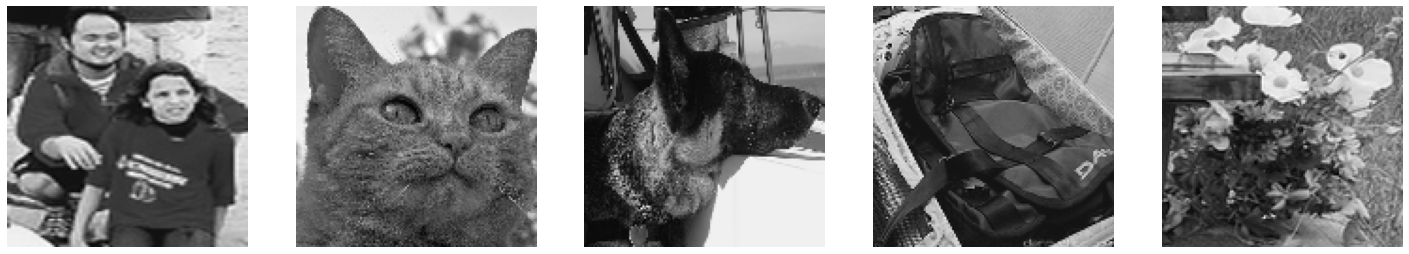

In [7]:
example_images = [10, 2965, 718, 714, 773]
example_image_collection = images[example_images]
visualize_ims(example_image_collection)

### Preprocessing
Our project included testing and extraction of many types of features to build out a successful classifier. The COCO dataset offers a significant number of images that include people, pets, and other household items, however these images are not isolated to a single image. To make things easier for our classifier we extracted our preselected categories from the image, ensured they would be sufficiently large to extract features, and standardized their shape.


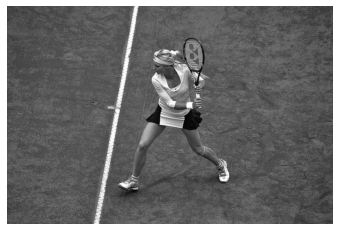

In [8]:
img = coco.loadImgs(ids[1099])[0]

I = io.imread(img['coco_url'], as_gray=True)
plt.axis('off')
plt.imshow(I, cmap="gray")
plt.show()

Since the COCO images include pose estimation and bounding boxes of figures within the image, it made feature extraction a fairly simple process. We can easily use the bounding box to extract a single person feature and resize it to work within our model.

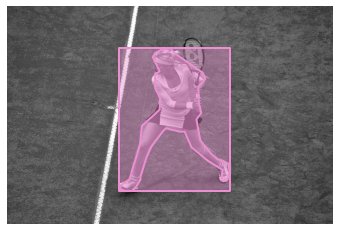

In [9]:
plt.imshow(I, cmap="gray"); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

Image categories were also a significant issue. Given the nature of the COCO photos, we had severely imbalanced classes. Most of our photos were of people and the first few baseline models demonstrated that when our classifier refused to predict an image as anything other than a person. We went back to preprocessing and randomly selected indices of people-images and selected only as many people as our largest minority class. 

<BarContainer object of 5 artists>

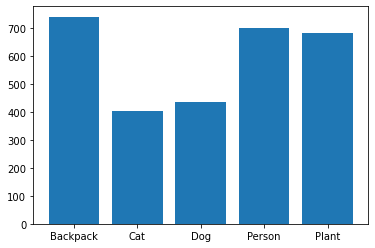

In [10]:
cats = {
    1:"Person",
    17:"Cat",
    18:"Dog",
    27:"Backpack",
    64:"Plant"
}
a = np.vectorize(cats.get)(image_labels)

unique, counts = np.unique(a, return_counts=True)
plt.bar(unique, counts)

Below we conduct our image standardization which creates images of the same size and shape across our entire dataset.

![standard_people](final_report/image_preprocessing.png)

To up-sample our other categories we also horizontally flipped images of cats, dogs, backpacks, and potted plants. This allowed us to double the size of those classes while providing the model mirrored data that would generalize to new images.

![og_image](final_report/flipped_im.png)

![flipped_im](final_report/Original_im.png)

### Feature Extraction
Once we completed the feature preprocessing, we were able to start developing and testing features. To aid in the explanation of our model features, I will be using an image of a cat I found in the COCO dataset that I have decided to name Frank. Since our model would be focusing on the shapes and contours that comprise people, pets, and household items, we were interested in various features that would identify edges, gradients, and shapes within the image.


#### Canny Features

In [11]:
canny_feats = np.zeros(images.shape)
for im in range(0,images.shape[0]):
    edges = cv2.Canny(np.uint8(images[im]*255),100,200, L2gradient = True)
    canny_feats[im,:,:] = edges

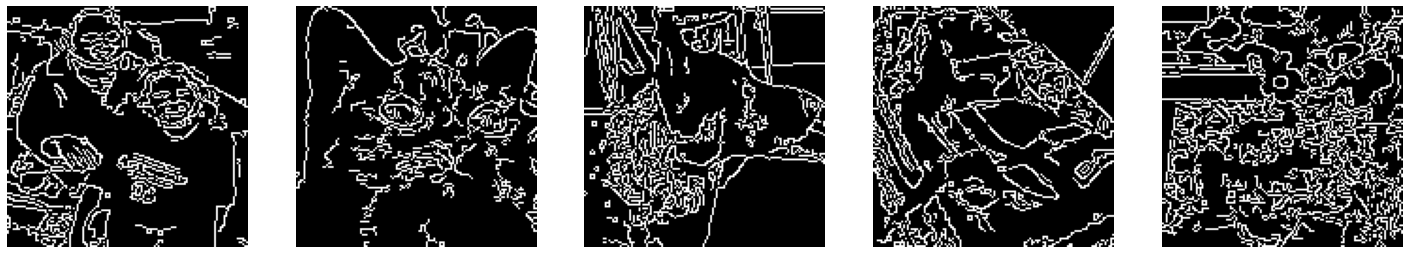

In [12]:
visualize_ims(canny_feats[example_images])

We tested a variety of Canny thresholds and apertures to create edge features to pass into our classifier. Once we passed them to our model, we saw overfitting and poor performance. Though Canny features were generally helpful for tracing our image subjects, they had too much detail to be helpful in our classification, even with the smallest aperture size. While Canny works to some degree on the Person, Cat, and Dog classes, it is difficult to decipher when applied to Backpacks and Plants.

This is likely a result of how we did our preprocessing. Since we cropped and resized all our images to include solely one category, there's significantly less noise in the baseline images. As we're only interested in high level features like ears or a head, the canny features detecting minute details wasn't helpful.

The next step in feature extraction was to create Histogram of Oriented Gradients features. This would deal with the detail issue and hopefully present a better idea of key category features.

#### HOG Features

In [2]:
im_hog = []
for i in example_image_collection:
    im_hog.append(skimage.feature.hog(i, orientations=6, pixels_per_cell=(16, 16), 
                            cells_per_block=(2, 2), visualize=True)[1])

im_hog = np.array(im_hog)

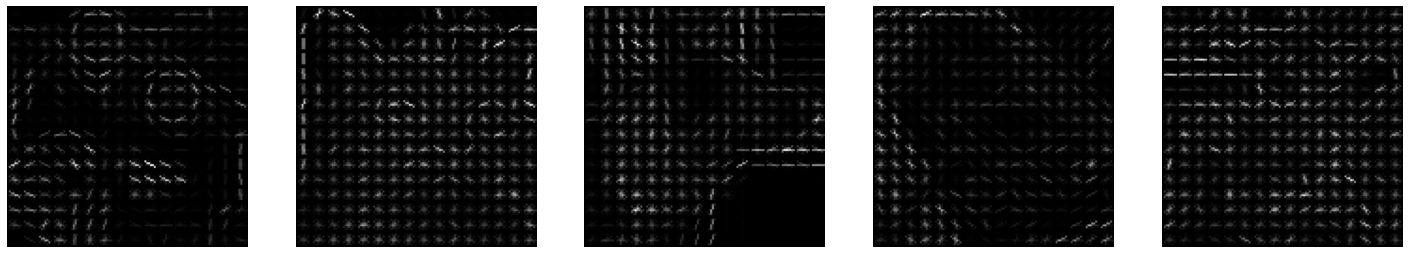

In [14]:
visualize_ims(im_hog)

Our Histogram of Oriented Gradients features looked the best when it came to deciphering features from our images. Looking at our "living" classes with People, Dogs, and Cats we clearly see heads, ears, and eyes. This makes the classification a little more difficult between classes as we'll discuss later, but we're starting to extract reasonable features from our images. We tried various combinations of orientations, pixels per cell, and cell per block using a validation set; our best results came using 6 orientations, 16x16 pixels per cell, and 2x2 cells per block, which captured high level features while reducing overfitting seen with more orientations and smaller cell sizes.

Passing HOG features into our classifier should work fairly well given its success at defining edges for our image classes. This is especially likely since our preprocessing focuses on individuals alone and won't have to deal with the excessive noise we would otherwise see in an unprocessed image. Clearing away image noise lets our model learn based on the features of an image rather than the noise.

#### Daisy Features

In [15]:
daisy_ims = [daisy(i, visualize=True) for i in example_image_collection]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


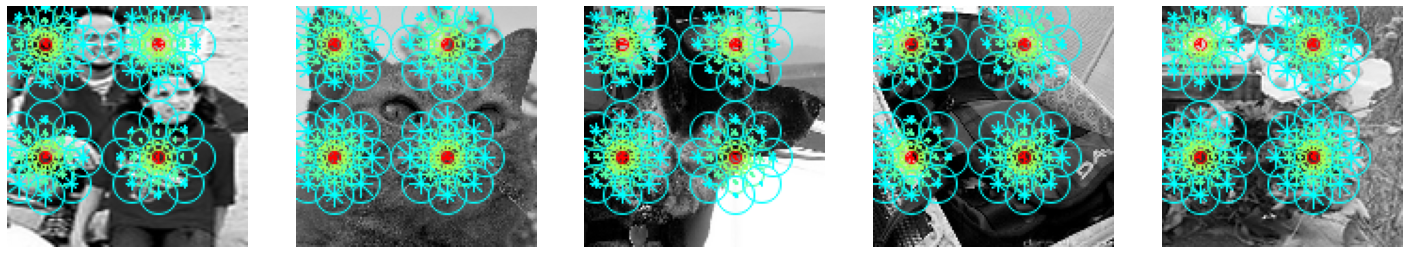

In [16]:
daisy_viz = []
for i in example_image_collection:
    daisy_viz.append(daisy(i, visualize=True, step = 60, radius = 20)[1])
    
daisy_viz = np.array(daisy_viz)
visualize_ims(daisy_viz)

Seeing the success of HOG on our image dataset, we wanted to test what something like DAISY, a dense representation of scale-invariant features, would do for our model. This Bag of Visual Words approach would allow us to use keypoints and descriptors to accrue key features within our images without solely relying on pixel gradients like our HOG features do. This step up would theoretically be incredibly helpful for separating classes that share facial features.

As we heavily leaned into the preprocessing and isolated just the image we were interested in classifying, DAISY wasn’t operating on particularly dense features. This is likely a result of filtering out noise and any other categories from the rest of the image. Ultimately, DAISY didn’t result in significant results that would’ve been useful to the model.

# Classification

#### PCA & tSNE

We applied PCA and tSNE with 2 components to our HOG and Canny feature vectors to visualize our data. The Canny features did not separate into clear clusters and had extremely dense overlap of classes at a singular point. The PCA HOG features formed loose overlapping clusters.

![](final_report/pca_tsne.png)

#### MLP Results

We trained a multi-layer perceptron classifier using GridSearchCV to select optimal hyperparameters from alpha values between 5 and 75, various layer numbers and sizes, and activation functions 'relu', 'logistic', and 'tanh'. We trained models on the HOG features, Canny features, combination of HOG and Canny features, PCA HOG features, PCA canny features, and PCA of the combined features. Our best model was on the HOG features with strong L2 regularization (alpha: 75), a tanh activation function, layer sizes (128,5), and max 500 iterations. The Canny features performed poorly with significantly lower precision and recall.

![](final_report/MLP_HOG_final.png)

#### SVC Results

We trained a support vector classifier using GridSearchCV to select optimal hyperparameters from C values between 0.1 and 2 and kernel types 'rbf', 'poly', and 'sigmoid'. As with the MLP classifier, we trained models on all our different feature vector types. Our best model was on the HOG features with C = 0.2 and a sigmoid kernel. The performance was slightly better than the MLP classifier. We saw significant overfitting in our training set with lower levels of regularization.

![](final_report/SVC_HOG_final.png)

# Generalizability

#### Hyperparameter Tuning
We tuned hyperparameters using GridSearchCV with k = 1 because of our small dataset. Both our best MLP model and our best SVC model had strong regularization parameters that addressed overfitting in the train set and made our model generalizable.

#### Overfitting

Our model's success is largely a result of the preprocessing of our features to exclude image noise and focus solely on the image category. Our model however did struggle with overfitting. Given the nature of a MLP model, it held a high risk of overfitting as we were already passing in powerful features into a powerful model. Initial models quickly ran into this issue resultinng in training accuracy of 97% and a testing accuracy of 31%.

![](final_report/MLP_Canny.png)

To combat overfitting, we implemented early stopping in the MLP model, lowered the maximum number of iterations, and changed the solver and alpha parameters. This helped reign in the MLP model and bring the training and test accuracies closer together.

```python
clf = MLPClassifier(solver='lbfgs', 
                    activation='relu', 
                    alpha=50, 
                    hidden_layer_sizes=(64, 5), 
                    random_state=1, 
                    max_iter=200,
                    early_stopping=True,
                    verbose=verbose)
```

#### Limitations

Applicability of any model is always going to be limited by the quality of the data. Given that our data came from COCO and was already fairly preprocessed to include bounding boxes and identified categories, we would need the same degree of preprocessing or at least an attention layer to identify image subjects. This is much easier to do on labeled data like COCO, but could require more hands on labeling and processing before being implemented in a production context on edge devices.

As we also saw in our classification, classes like People, Dogs, and Cats can potentially share facial features. As we continue to add more classes, we run the risk of further misclassifying any category that includes a face. Further work should include more features that can separate facial features between classes.

The model, while fairly successful, likely falls short of generalizability. The dataset ended up fairly limited in class size and could've benefitted from more labeled images of our project classes. This would've allowed us to have more diversity of images in our training data and given our model the opportunity to better learn facial features that could've supported our Bag of Visual Words image approach that ultimately failed with DAISY features.